# Transcript from lecture, March 9, 2023

# Visualizing optimization algorithms

This notebook is based on Louis Tiao's posts and software at [http://louistiao.me/]. Any errors are of course my own.

In this series of notebooks, we demonstrate some useful patterns and recipes for visualizing animating optimization algorithms using Matplotlib.

In [1]:
%matplotlib inline
# %matplotlib tk

import matplotlib.pyplot as plt
import autograd.numpy as np

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from autograd import elementwise_grad, value_and_grad
from scipy.optimize import minimize
from collections import defaultdict
from itertools import zip_longest
from functools import partial

In [2]:
plt.close('all')

We shall restrict our attention to 3-dimensional problems for right now (i.e. optimizing over only 2 parameters), though what follows can be extended to higher dimensions by plotting all pairs of parameters against each other, effectively projecting the problem to 3-dimensions. 

The Wikipedia article on [Test functions for optimization](https://en.wikipedia.org/wiki/Test_functions_for_optimization) has a few functions that are useful for evaluating optimization algorithms. One often-used example is **Beale's function**:

$$
f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
$$

Other examples are the quadratic function that Gil **Strang** (and we) will use in lectures about gradient descent,

$$
f(x, y) = (x^2 + \alpha y^2)/2 \;\;\; \mbox{where we usually take $\alpha=1/10$},
$$

and **Rosenbrock's function**, a simple-looking but notoriously tricky one,

$$
f(x, y) = (1 - x)^2 + \alpha(y-x^2)^2 \;\;\; \mbox{where we will take $\alpha = 100$}.
$$


In [3]:
# Define the objective function, the grid we will visualize it on, and the starting point.
# Also, since we know the minimum of each of these functions, record that for reference too.

# function = 'Strang'
function = 'Rosenbrock'

if function == 'Beale':
    # Beale's function. See https://en.wikipedia.org/wiki/Test_functions_for_optimization
    f  = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2
    contours = np.logspace(0, 5, 35)
    minima = np.array([3., .5])
    x0 = np.array([3., 4.])
    
elif function == 'Rosenbrock':
    # Rosenbrock's function. See https://en.wikipedia.org/wiki/Test_functions_for_optimization
    alpha = 100
    f = lambda x, y: (1.0 - x)**2 + alpha * (y-x**2)**2
    xmin, xmax, xstep = -3.5, 2., .05
    ymin, ymax, ystep = -5., 5., .05
    contours = np.logspace(0, 5, 35)
    minima = np.array([1., 1.]) 
    x0 = np.array([-3., -4.])
    
elif function == 'Strang':
    # The simple quadratic from Gil Strang's lectures on optimization
    alpha = 0.1
    f = lambda x, y: (x**2 + alpha*y**2) / 2 
    xmin, xmax, xstep = -1., 1., .1
    ymin, ymax, ystep = -1., 1.5, .1
    contours = np.logspace(-2, 0, 20)
    minima = np.array([0.,0.])
    x0 = np.array([alpha,1.])
    
else:
    assert False
    



In [4]:
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))

In [5]:
z = f(x, y)
z

array([[29776.5     , 28589.253125, 27442.72    , ...,  7414.02    ,
         7749.303125,  8101.      ],
       [29604.25    , 28420.478125, 27277.37    , ...,  7328.17    ,
         7661.528125,  8011.25    ],
       [29432.5     , 28252.203125, 27112.52    , ...,  7242.82    ,
         7574.253125,  7922.      ],
       ...,
       [ 5422.5     ,  4923.303125,  4454.92    , ...,   167.22    ,
          121.353125,    82.      ],
       [ 5349.25    ,  4853.528125,  4388.57    , ...,   180.37    ,
          132.578125,    91.25    ],
       [ 5276.5     ,  4784.253125,  4322.72    , ...,   194.02    ,
          144.303125,   101.      ]])

In [6]:
print(f'known minimum is at argmin(f) = {minima}, with f(argmin(f)) = {f(*minima)}')

known minimum is at argmin(f) = [1. 1.], with f(argmin(f)) = 0.0


In [7]:
# Make argmin into a numpy array for ease of manipulation
minima_ = minima.reshape(-1, 1)

print(minima_)
print()
print(f(*minima_))

[[1.]
 [1.]]

[0.]


### 3D Surface Plot

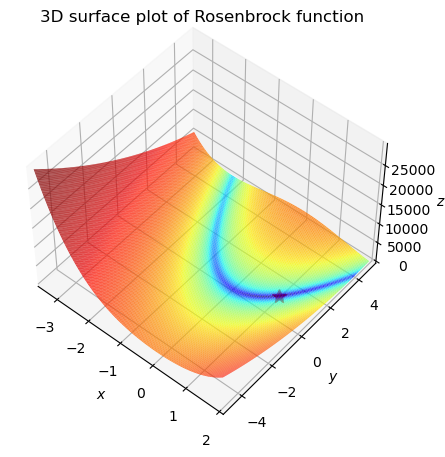

In [8]:
fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)

ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.set_title(f"3D surface plot of {function} function")

plt.show()

### Gradient-based Optimization

For the purposes of this demonstration, we use [SciPy's optimization methods](http://docs.scipy.org/doc/scipy/reference/optimize.html). It goes without saying that the code and patterns for producing these visualizations generalizes easily to other optimization tools and libraries.

For Beale, we set the starting point as $(3, 4)$, since it is challenging for algorithms with a little too much momentum in the gradient descent update rule, as they may overshoot and end up in some local minima. For the other functions we pick interesting starting points.

In [9]:
if function == 'Beale':
    x0 = np.array([3., 4.])
    
elif function == 'Rosenbrock':
    x0 = np.array([-3., -4.])
    
elif function == 'Strang':
    x0 = np.array([alpha,1.])
    
else:
    assert False

Again, we use `autograd` to compute the gradients, and augment the function slightly to adhere to Scipy's optimization interface.

In [11]:
func = value_and_grad(lambda args: f(*args))

The method we use first is `Newton-CG`, and set the callback simply as `print`. Note that we can only do this in Python 3, where [`print` is an actual function](https://docs.python.org/3.0/whatsnew/3.0.html#print-is-a-function).

In [12]:
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=print)

[-1.74742273 -3.79134412]
[-0.82197159 -3.52684331]
[-0.11897863 -3.10034202]
[-0.11748865 -0.51240847]
[ 0.00286327 -0.04267604]
[0.01307139 0.00211977]
[0.11998128 0.00478589]
[0.21151694 0.02967163]
[0.36709525 0.10741914]
[0.35798936 0.12553332]
[0.45598375 0.19630567]
[0.45286813 0.20332893]
[0.5430333 0.2853871]
[0.54018579 0.29009412]
[0.60727087 0.3629049 ]
[0.60576978 0.36565497]
[0.71851034 0.50271394]
[0.71308814 0.5071252 ]
[0.76599236 0.58289765]
[0.76486638 0.58411671]
[0.84318293 0.70427558]
[0.84065819 0.70601477]
[0.86354667 0.74461059]
[0.91272201 0.8300258 ]
[0.91164104 0.83072866]
[0.95264128 0.90566313]
[0.95197619 0.90606598]
[0.95784795 0.91727001]
[0.97049512 0.94156142]
[0.99833325 0.99589432]
[0.99802686 0.99604944]
[0.99999678 0.99998968]
[0.99999524 0.99999046]
[1.00000001 1.00000003]
[1.00000001 1.00000002]
[1. 1.]
[1. 1.]
[1. 1.]


In [13]:
dict(res)

{'fun': 6.357933059830101e-19,
 'jac': array([ 5.67418777e-10, -1.07924780e-09]),
 'nfev': 47,
 'njev': 126,
 'nhev': 0,
 'status': 0,
 'success': True,
 'message': 'Optimization terminated successfully.',
 'x': array([1., 1.]),
 'nit': 38}

The results look plausibly good, but would be more convincing with some visualization. Let us define a new callback function that appends the intermediate values to a list instead of simply printing it.

In [14]:
def make_minimize_cb(path=[]):
    
    def minimize_cb(xk):
        # note that we make a deep copy of xk
        path.append(np.copy(xk))

    return minimize_cb

We initialize the list with the starting value.

In [15]:
path_ = [x0]

In [16]:
res = minimize(func, x0=x0, method='Newton-CG',
               jac=True, tol=1e-20, callback=make_minimize_cb(path_))

In [17]:
dict(res)

{'fun': 6.357933059830101e-19,
 'jac': array([ 5.67418777e-10, -1.07924780e-09]),
 'nfev': 47,
 'njev': 126,
 'nhev': 0,
 'status': 0,
 'success': True,
 'message': 'Optimization terminated successfully.',
 'x': array([1., 1.]),
 'nit': 38}

We cast the list to a NumPy array and transpose it so it's easier and more natural to work with.

In [18]:
path = np.array(path_).T
path.shape

(2, 39)

### Static Quiver Plot of Path on 2D Contour Plot

Again, using the `quiver` method, but in a slightly different way than before, we can represent each step, its length and direction, using the arrows.

Text(0.5, 1.0, "Newton's method for Rosenbrock function")

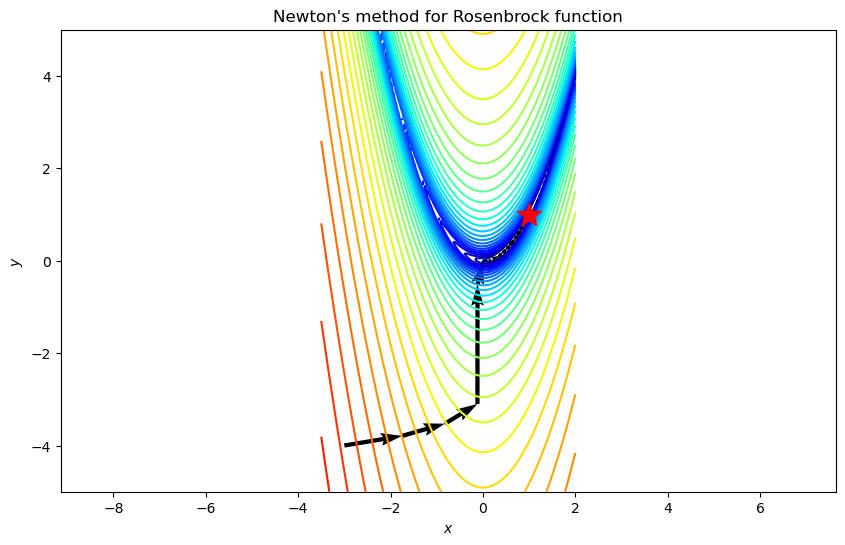

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=contours, norm=LogNorm(), cmap=plt.cm.jet)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1], 
          scale_units='xy', angles='xy', scale=1, width=(xmax-xmin)/1000, color='k')
ax.plot(*minima_, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.axis('equal')
ax.set_title(f"Newton's method for {function} function")

### Modularizing and Generalizing to Animate Multiple Paths Simultaneously

Instead of initializing the line and point in the global scope, and defining the animation callback functions to use those global variables, we can encapsulate everything in a closure. 

Or better yet, we could just create subclass of `FuncAnimation` that is initialized with a variable number of paths to plot. In the initialization method, we just create and save the list of `Line2D` objects as attributes, and define animation callback methods that use these attributes.

In [ ]:
class TrajectoryAnimation(animation.FuncAnimation):
    
    def __init__(self, *paths, labels=[], fig=None, ax=None, frames=None, 
                 interval=60, repeat_delay=5, blit=True, **kwargs):

        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()

        self.fig = fig
        self.ax = ax
        
        self.paths = paths

        if frames is None:
            frames = max(path.shape[1] for path in paths)
  
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                      for _, label in zip_longest(paths, labels)]
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                       for line in self.lines]

        super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                                  frames=frames, interval=interval, blit=blit,
                                                  repeat_delay=repeat_delay, **kwargs)

    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points

    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[::,:i])
            point.set_data(*path[::,i-1:i])
        return self.lines + self.points

### SciPy' Gradient-based Optimization Algorithms

Now let's take these newly defined classes out for a spin! Let us simultaneously animate SciPy's gradient-based optimization algorithms.

In [ ]:
methods = [
#   "CG",
#   "BFGS",
    "Newton-CG",
    "L-BFGS-B",
#   "TNC",
#   "SLSQP",
#   "dogleg",
#   "trust-ncg"
]

We do some partial function application here to reduce the amount of code required..

In [ ]:
minimize_ = partial(minimize, fun=func, x0=x0, jac=True, bounds=[(xmin, xmax), (ymin, ymax)], tol=1e-20)

Initialize the trajectories

In [ ]:
paths_ = defaultdict(list)
for method in methods:
    paths_[method].append(x0)

We expected these warnings, and can safely ignore them here.

In [ ]:
results = {method: minimize_(method=method, callback=make_minimize_cb(paths_[method])) for method in methods}

In [ ]:
paths = [np.array(paths_[method]).T for method in methods]

In [ ]:
zpaths = [f(*path) for path in paths]
zpaths = None

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.contour(x, y, z, levels=contours, norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima_, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title(f"Comparing methods on {function} function")

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
ax.axis('equal')

anim = TrajectoryAnimation(*paths, labels=methods, ax=ax)

ax.legend(loc='upper left')

In [ ]:
HTML(anim.to_html5_video())

Having the `TrajectoryAnimation` class at our disposal makes it incredibly simple to not only visualize, but animate optimization procedures, and allows us to better understand and be able to visually debug the optimization problems and algorithms we are working with. 

Furthermore, the fact that `TrajectoryAnimation` is a subclass of `FunAnimation` means we have the flexibility of exporting and presenting these animations in a variety of formats, e.g. exporting as GIFs, embedding them in Jupyter Notebooks as HTML5 videos. This can make our presentations far more compelling.

In future posts in this series, we will demonstrate these methods on other objective functions, other optimization algorithms in other libraries such as [TensorFlow](https://www.tensorflow.org/versions/r0.8/api_docs/python/train.html#optimizers), and generalize to higher-dimensional problems.